In [1]:
%pip uninstall -qqqy google-generativeai google-ai-generativelanguage docx
%pip install -qU "langchain[google-genai]" langchain langgraph>0.2.27 langchain_community pypdf faiss-cpu langchain-tavily langchain-huggingface langgraph-checkpoint-sqlite rank_bm25 unstructured python-docx
import os
import getpass
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
load_dotenv()
# .env should also have TAVILY_API_KEY
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "default"
if not os.environ.get("TAVILY_API_KEY"):
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter API key for Tavily: ")
if not os.environ.get("HF_TOKEN"):
  os.environ["HF_TOKEN"] = getpass.getpass("Enter API key for Hugging Face: ")
if not os.environ.get("GEMINI_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")
else:
  os.environ["GOOGLE_API_KEY"] = os.environ.get("GEMINI_API_KEY")
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
from langchain.chat_models import init_chat_model
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_store = InMemoryVectorStore(embeddings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
from typing import Iterable, Optional, List
from pathlib import Path
from langchain.schema import Document
from langchain_community.document_loaders import (
    WebBaseLoader, PyPDFLoader, TextLoader, UnstructuredMarkdownLoader,
    CSVLoader, UnstructuredWordDocumentLoader
)
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.chat_models import init_chat_model
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition
from typing import Dict, Any
from bs4 import SoupStrainer


class UniversalRAG:
    def __init__(self,
                 embedding_model: str = "sentence-transformers/all-mpnet-base-v2",
                 llm_model: str = "gemini-2.0-flash"):
        self.embeddings = HuggingFaceEmbeddings(model_name=embedding_model)
        self.vectorstore = None
        self.llm = init_chat_model(llm_model, model_provider="google_genai")

    def load_web(self, urls: Iterable[str], css_main: Optional[str] = None) -> List[Document]:
        docs = []
        for url in urls:
            bs_kwargs = {}
            if css_main:
                bs_kwargs["parse_only"] = SoupStrainer(css_main)
            loader = WebBaseLoader(url, bs_kwargs=bs_kwargs)
            docs.extend(loader.load())
        return docs

    def load_files(self, paths: Iterable[str]) -> List[Document]:
        docs = []
        for path in paths:
            ext = Path(path).suffix.lower()
            if ext == ".pdf":
                loader = PyPDFLoader(path)
            elif ext in [".txt", ".log"]:
                loader = TextLoader(path, encoding="utf-8")
            elif ext in [".md", ".markdown"]:
                loader = UnstructuredMarkdownLoader(path)
            elif ext == ".csv":
                loader = CSVLoader(path)
            elif ext in [".docx", ".doc"]:
                loader = UnstructuredWordDocumentLoader(path)
            else:
                raise ValueError(f"Unsupported file type: {ext}")
            docs.extend(loader.load())
        return docs

    def chunk(self, docs: List[Document], chunk_size: int = 1000, chunk_overlap: int = 200) -> List[Document]:
        splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        return splitter.split_documents(docs)

    def build_vectorstore(self, docs: List[Document]):
        self.vectorstore = FAISS.from_documents(docs, self.embeddings)

    def retrieve(self, query: str, k: int = 4) -> List[Document]:
        if not self.vectorstore:
            raise ValueError("Vectorstore not built. Call build_vectorstore first.")
        return self.vectorstore.similarity_search(query, k=k)

    def render_prompt(self, question: str, context_docs: List[Document]) -> str:
        context_text = "\n\n".join(doc.page_content for doc in context_docs)
        return f"Answer the question based on the context below.\n\nContext:\n{context_text}\n\nQuestion: {question}\nAnswer:"

    def generate(self, question: str, context_docs: List[Document]) -> str:
        prompt = self.render_prompt(question, context_docs)
        response = self.llm.invoke(prompt)
        return response.content if hasattr(response, "content") else str(response)

    def ask(self, question: str) -> str:
        context_docs = self.retrieve(question)
        return self.generate(question, context_docs)


def node_load_and_chunk(state: Dict[str, Any]) -> Dict[str, Any]:
    docs_web = rag.load_web(state.get("urls", []), css_main=state.get("css_main"))
    docs_files = rag.load_files(state.get("file_paths", []))
    all_docs = rag.chunk(docs_web + docs_files)
    return {**state, "docs": all_docs}

def node_build_vs(state: Dict[str, Any]) -> Dict[str, Any]:
    rag.build_vectorstore(state["docs"])
    return state

def node_retrieve(state: Dict[str, Any]) -> Dict[str, Any]:
    retrieved_docs = rag.retrieve(state["question"], k=state.get("top_k", 4))
    return {**state, "context_docs": retrieved_docs}

def node_generate(state: Dict[str, Any]) -> Dict[str, Any]:
    answer = rag.generate(state["question"], state["context_docs"])
    return {**state, "answer": answer}


In [9]:
rag = UniversalRAG()
graph_builder = StateGraph(dict)

graph_builder.add_node("load_and_chunk", node_load_and_chunk)
graph_builder.add_node("build_vs", node_build_vs)
graph_builder.add_node("retrieve", node_retrieve)
graph_builder.add_node("generate", node_generate)

graph_builder.set_entry_point("load_and_chunk")
graph_builder.add_edge("load_and_chunk", "build_vs")
graph_builder.add_edge("build_vs", "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

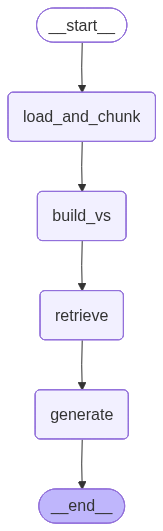

In [10]:
from IPython.display import Image, display
from langgraph.graph import MessagesState, StateGraph
graph_builder = StateGraph(MessagesState)
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
rag = UniversalRAG()

# Load from web with/ CSS filter
docs_web = rag.load_web(
    ["https://numpy.org/doc/2.3/user/whatisnumpy.html"]
)

# Load from multiple file types
docs_files = rag.load_files([
    "sample.pdf",
    "notes.txt",
    "report.md",
    "data.csv",
    "proposal_content.docx"
])

# Chunk, embed, store
all_docs = rag.chunk(docs_web + docs_files)
rag.build_vectorstore(all_docs)

# Ask a question
print(rag.ask("Summarize the main concepts from the documents."))


*   **Financial Reporting and Estimates:** The preparation of financial statements requires management to make estimates and assumptions based on historical experience and other factors. If these estimates are incorrect, the company's operating results could be adversely affected.

*   **Internal Control Over Financial Reporting:** The company's internal controls are designed to ensure the accurate and reliable recording of transactions and the prevention of unauthorized use of assets. However, these controls have inherent limitations and may not prevent or detect all misstatements.

*   **Business Risks:** The company faces various risks related to its ability to execute strategies, the availability of resources, unforeseen difficulties, research outcomes, regulatory compliance, customer acceptance, and competitive actions.

*   **Data Aesthetics in RAG:** Clean, relevant, and semantically coherent data is crucial for generating elegant answers in Retrieval-Augmented Generation (RAG) 

In [12]:
initial_state = {
    "urls": ["https://numpy.org/doc/2.3/user/whatisnumpy.html"],
    "file_paths": ["sample.pdf", "notes.txt", "report.md", "data.csv", "proposal_content.docx"],
    "css_main": None,
    "question": "What is NumPy?",
    "top_k": 3
}

final_state = graph.invoke(initial_state)
print(final_state["answer"])

NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more. At the core of the NumPy package, is the ndarray object, which encapsulates n-dimensional arrays of homogeneous data types, with many operations being performed in compiled code for performance.


In [13]:
print(rag.ask("why is numpy fast"))

NumPy is fast because it utilizes vectorization, which executes element-by-element operations using pre-compiled C code "behind the scenes." This avoids the overhead of interpreting Python code and manipulating Python objects for each element, resulting in near-C speeds while maintaining the simplicity of Python code.


In [14]:
print(rag.ask("How to beat The Legend of Zelda : Breath of the Wild?"))

This document does not contain information on how to beat "The Legend of Zelda: Breath of the Wild." It discusses Retrieval-Augmented Generation (RAG) systems, attention economics, failure modes in systems, the nature of tools, and includes a product description for a Lenovo laptop.
